### Install dependencies

In [32]:
# same deal for gdrive and kaggle
from google.colab import drive
drive.mount('/content/drive')

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# install dataset and unzip

!rm -r dataset

!kaggle datasets download -d saumitgp/occupancy-detection-dataset
!mkdir dataset
!unzip occupancy-detection-dataset.zip -d dataset

occupancy-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  occupancy-detection-dataset.zip
  inflating: dataset/OccupancyData/DataTest.csv  
  inflating: dataset/OccupancyData/DataTraining.csv  


In [34]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# the balance is weird, I will merge the train and test files first and split them to 8:2
df = pd.concat([
        pd.read_csv('dataset/OccupancyData/DataTraining.csv',index_col=[0]),
        pd.read_csv('dataset/OccupancyData/DataTest.csv',index_col=[0])
    ])
raw_vals = df.drop(columns=['date']).values
X,y = raw_vals[:,:-1],raw_vals[:,-1]
# pad X with 1 in the beginning, this will serve as our bias term
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=0)

# decision trees don't need scaling! :)

In [35]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score

def k_fold_validation(clf,X_train,y_train,n_folds=10):
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    folds = np.array_split(idxs,n_folds)
    all_scos = []
    for i in tqdm(range(n_folds),desc=f'{n_folds} folds validation...'):
        holdout = folds[i]
        rest = np.hstack([f for j,f in enumerate(folds) if not j == i])
        clf.fit(X_train[rest],y_train[rest])
        res = {
            'accuracy': clf.score(X_train[holdout],y_train[holdout]),
            'f1': f1_score(y_train[holdout],clf.predict(X_train[holdout]))
        }
        all_scos.append(res)
    return pd.DataFrame(all_scos)

### Task 1

Implement a Decision Tree Classifier for your classification problem. You may use a built-in package to implement your classifier. Try modifying one or more of the input parameters and describe what changes you notice in your results. Clearly describe how these factors are affecting your output.


I tried modifying some leaf conditions, complexity and depth of the tree. However, all the trees returned very simlar performance. I believe this was due to the dataset being too learnable.

In [36]:
from sklearn.tree import DecisionTreeClassifier

results = []
# maximum depth of the tree
for d in [1,2,3,4,5,6]:
    for l in [1,.4,.3,.2,.1,.05]:
    # ccp_alpha, this is basically the complexity threshold
        # for alpha in [0,.1,.3]:
        params = {
            'random_state': 0,
            'max_depth': d,
            # 'ccp_alpha': alpha,
            'min_samples_leaf':l
        }
        tree = DecisionTreeClassifier(**params)

        train_res = k_fold_validation(tree,X_train,y_train).mean()

        tree.fit(X_train,y_train)
        results.append({
            **params,
            'train_acc': train_res.accuracy,
            'train_f1': train_res.f1,
            'test_acc': tree.score(X_test,y_test),
            'test_f1': f1_score(y_test,tree.predict(X_test)),
        })

results = pd.DataFrame(results)

results

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

,random_state,max_depth,min_samples_leaf,train_acc,train_f1,test_acc,test_f1
0,0,1,1.00,0.991757,0.980740,0.987147,0.970663
1,0,1,0.40,0.789676,0.000000,0.785694,0.000000
2,0,1,0.30,0.909750,0.823802,0.902207,0.814028
3,0,1,0.20,0.991338,0.979688,0.987147,0.970663
4,0,1,0.10,0.991617,0.980390,0.987147,0.970663
5,0,1,0.05,0.991618,0.980345,0.987147,0.970663
6,0,2,1.00,0.992037,0.981335,0.987427,0.971283
7,0,2,0.40,0.789676,0.000000,0.785694,0.000000
8,0,2,0.30,0.909822,0.823454,0.902207,0.814028
9,0,2,0.20,0.991618,0.980270,0.987147,0.970663


[(0.95, 1.0),
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6')],
 Text(0.5, 1.0, 'Test F1 by depth')]

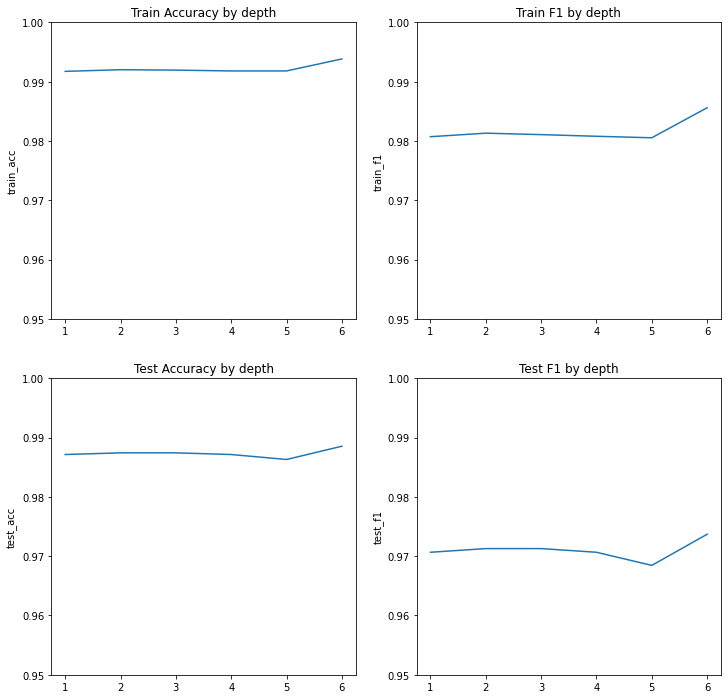

In [37]:
# plot by max depth
import matplotlib.pyplot as plt
import seaborn as sns

by_depth = results[results.min_samples_leaf == 1].reset_index(drop=True)
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(12,12))
sns.lineplot(
    data=by_depth.train_acc,
    ax=axes[0,0]
).set(
    xticklabels=[0] + by_depth.max_depth.tolist(),
    ylim=(.95,1),
    title='Train Accuracy by depth'
)
sns.lineplot(
    data=by_depth.train_f1,
    ax=axes[0,1]
).set(
    xticklabels=[0] + by_depth.max_depth.tolist(),
    ylim=(.95,1),
    title='Train F1 by depth'
)
sns.lineplot(
    data=by_depth.test_acc,
    ax=axes[1,0]
).set(
    xticklabels=[0] + by_depth.max_depth.tolist(),
    ylim=(.95,1),
    title='Test Accuracy by depth'
)
sns.lineplot(
    data=by_depth.test_f1,
    ax=axes[1,1]
).set(
    xticklabels=[0] + by_depth.max_depth.tolist(),
    ylim=(.95,1),
    title='Test F1 by depth'
)

[(0.0, 1.0),
 [Text(0, 0, '0'),
  Text(0, 0, '1.0'),
  Text(0, 0, '0.4'),
  Text(0, 0, '0.3'),
  Text(0, 0, '0.2'),
  Text(0, 0, '0.1'),
  Text(0, 0, '0.05')],
 Text(0.5, 1.0, 'Test F1 by leaf split')]

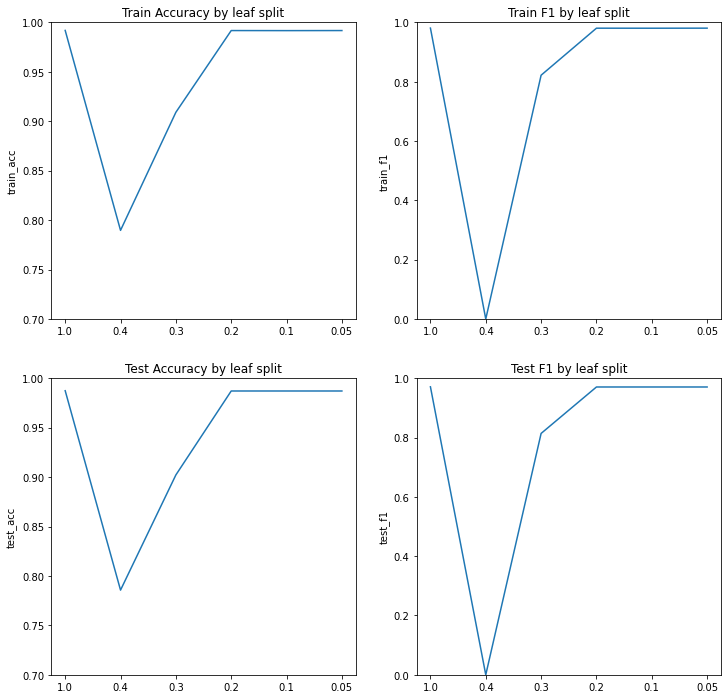

In [38]:
# plot by max depth
import matplotlib.pyplot as plt
import seaborn as sns

by_split = results[results.max_depth == 3]
fig,axes = plt.subplots(ncols=2,nrows=2,figsize=(12,12))
sns.lineplot(
    data=by_split.train_acc,
    ax=axes[0,0]
).set(
    xticklabels=[0] + by_split.min_samples_leaf.tolist(),
    ylim=(.7,1),
    title='Train Accuracy by leaf split'
)
sns.lineplot(
    data=by_split.train_f1,
    ax=axes[0,1]
).set(
    xticklabels=[0] + by_split.min_samples_leaf.tolist(),
    ylim=(0,1),
    title='Train F1 by leaf split'
)
sns.lineplot(
    data=by_split.test_acc,
    ax=axes[1,0]
).set(
    xticklabels=[0] + by_split.min_samples_leaf.tolist(),
    ylim=(.7,1),
    title='Test Accuracy by leaf split'
)
sns.lineplot(
    data=by_split.test_f1,
    ax=axes[1,1]
).set(
    xticklabels=[0] + by_split.min_samples_leaf.tolist(),
    ylim=(0,1),
    title='Test F1 by leaf split'
)

### Task 2

From the Bagging and Boosting ensemble methods pick any one algorithm 
from each category. Implement both the algorithms using the same data. Use k-fold cross 
validation to find the effectiveness of both the models. Comment on the difference/similarity of 
the results.

In [39]:
# bagging
# n_bags = 50
class BaggedTree:
    def __init__(self,n_bags):
        self.n_bags = n_bags
        self.bagged_models = []
    def fit(self,X_train,y_train):
        idxs = np.arange(X_train.shape[0])
        for _ in range(self.n_bags):
            subset = np.random.choice(idxs,X_train.shape[0] // self.n_bags )
            X_sub,y_sub = X_train[subset],y_train[subset]
            # Although this dataset is easier to learn, don't want the trees to overfit! 
            self.bagged_models.append(DecisionTreeClassifier(max_depth=4).fit(X_sub,y_sub))
        # now testing the mdoel
        return self
    def predict(self,X_test):
        # in this case, since the trees predict between 0 and 1, we split from .5
        return (np.vstack([m.predict(X_test) for m in self.bagged_models]).mean(0) > .5).astype(int)
        # accuracy = (preds == y_test).mean()
    def score(self,X_test,y_test):
        return (self.predict(X_test) == y_test).mean()


In [42]:
# Adaboost implementation
# this one takes a bit longer
class AdaBoost:
    def __init__(self,n_models):
        self.n_models = n_models
        self.boosted_models = [DecisionTreeClassifier(max_depth=1,random_state=0)] * n_models
        self.alphas = np.ones(n_models)
        self.errors = np.zeros(n_models)
    def fit(self,X_train,y_train):
        weights = np.ones_like(y_train) / y_train.shape[0]
        for i,m in enumerate(self.boosted_models):
            m.fit(X_train,y_train,sample_weight=weights)
            y_pred = m.predict(X_train)
            # identify missed examples
            misses = y_train * y_pred
            # calculate overall err
            err = (weights * misses).sum() / weights.sum()
            # reweight
            alpha = np.log((1-err)/err) * .5
            self.errors[i] = err
            self.alphas[i] = alpha
            weights *= np.exp(alpha * misses)
            # weights should always sum to 1
            weights /= weights.sum()
        return self
    def predict(self,X_test):
        outs = np.vstack([m.predict(X_test) for m in self.boosted_models])
        # although I have been using 0 and 1 for labels, for the convenience of caculating final outcome, 
        # the labels are temporarily converted to -1 and 1. 
        outs[outs==0] = -1
        return ((outs * self.alphas[:,None]).sum(0) > 0).astype(int)
    def score(self,X_test,y_test):
        return (self.predict(X_test) == y_test).mean()
 

In [ ]:
BAGS_TO_TRY = [1,2,10,20,50,100,200]
BOOSTS_TO_TRY = [1,2,5,10,20,50,100,200]

bagged_avgs = pd.concat([
    k_fold_validation(BaggedTree(n),X_train,y_train).mean()
    for n in BAGS_TO_TRY
],axis=1).T

print('bagging results:')
print(bagged_avgs)


ada_avgs = pd.concat([
    k_fold_validation(AdaBoost(n,n_iter=10),X_train,y_train).mean()
    for n in BOOSTS_TO_TRY
],axis=1).T

print('boosting results:')
print(ada_avgs)

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

bagging results:
   accuracy        f1
0  0.992316  0.981858
1  0.992037  0.981204
2  0.991967  0.981265
3  0.991827  0.980853
4  0.991827  0.980940
5  0.991827  0.980724
6  0.991618  0.980290


10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

10 folds validation...:   0%|          | 0/10 [00:00<?, ?it/s]

boosting results:
   accuracy        f1
0  0.991758  0.980501
1  0.991758  0.980636
2  0.991758  0.980653
3  0.991618  0.980344
4  0.991758  0.980603
5  0.991618  0.980315
6  0.991757  0.980662
7  0.991618  0.980476


[(0.95, 1.0),
 [Text(0, 0, '0'),
  Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '5'),
  Text(0, 0, '10'),
  Text(0, 0, '20'),
  Text(0, 0, '50'),
  Text(0, 0, '100'),
  Text(0, 0, '200')],
 Text(0.5, 1.0, 'AdaBoost trees F1')]

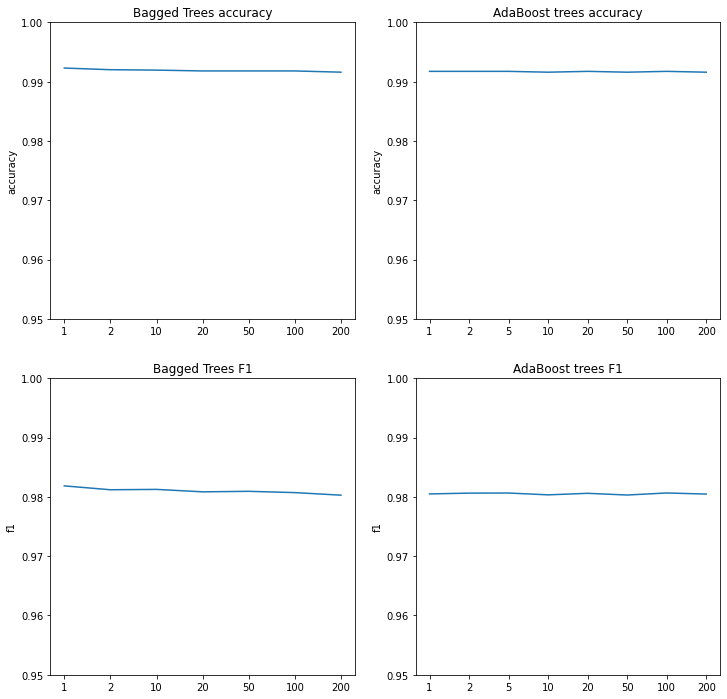

In [ ]:
fig,axes = plt.subplots(nrows=2, ncols = 2,figsize =(12,12))

# bagging is doing a bit too well and we can't tell. so setting the lims between .98 and 1
sns.lineplot(
    data=bagged_avgs.accuracy, 
    ax=axes[0,0]
).set(
    ylim=(.95,1),
    title='Bagged Trees accuracy',
    xticklabels=[0]+BAGS_TO_TRY
)
sns.lineplot(
    data=bagged_avgs.f1, 
    ax=axes[1,0]
).set(
    ylim=(.95,1),
    title='Bagged Trees F1',
    xticklabels=[0]+BAGS_TO_TRY
)
sns.lineplot(
    data=ada_avgs.accuracy,
    ax=axes[0,1]
).set(
    ylim=(.95,1), 
    title='AdaBoost trees accuracy',
    xticklabels=[0]+BOOSTS_TO_TRY
)
sns.lineplot(
    data=ada_avgs.f1, 
    ax=axes[1,1]
).set(
    ylim=(.95,1), 
    title='AdaBoost trees F1',
    xticklabels=[0]+BOOSTS_TO_TRY
)

### Task 3

Compare the effectiveness of the three models implemented above. Clearly 
describe the metric you are using for comparison. Describe (with examples) Why is this 
metric(metrics) suited/appropriate for the problem at hand? How would a choice of a different 
metric impact your results? Can you demonstrate that.



I made use of the F1 score and the classic accuracy score to check the effectiveness of the models. I chose the F1 score as a metric to use because it is a combinaton of the precision and recall scores, showing the robustness of the classifiers. Looking at these results, a classic decision tree with depth around 2~3 seems to achieve the best performance. The adaboost implementation (which I believe is correct) also performs pretty well, but it takes a bit longer than the classic tree while achieving similar performance, which is why I believe a classic dtree is good enough for this task. The bagged trees implementation did not work very well as the number of bags increased. Thus it seems that not splitting the dataset into random samples is not very effective in this case.

Trying with different parameters for the decision tree, it seems that increasing the number of samples required for leaf splits is actually not beneficial to the performance to the classifiers. 

Using the F1 score allowed me to get a better understanding of the performance of the classifiers, especially because the dataset is not well balanced (which I did not fix because logistic regression seemed to do well enough on it still), with a majority classifier score of ~ .72. If I had only used the accuracy score, this performance might have appeared OK, but upon inspecting the F1 scores, I was able to tell that the classifiers were simply predicting one label. 